In [1]:
#Here is the function to fetch the data
# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
import os

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [62]:
invoice_test = pd.read_csv('invoice_test.csv',low_memory=False)
invoice_train = pd.read_csv('invoice_train.csv',low_memory=False)
client_test = pd.read_csv('client_test.csv',low_memory=False)
client_train = pd.read_csv('client_train.csv',low_memory=False)
sample_submission = pd.read_csv('SampleSubmission (2).csv',low_memory=False)

In [63]:
#compare size of the various datasets
print(client_train.shape, invoice_train.shape, client_test.shape, invoice_train.shape)

(135493, 6) (4476749, 16) (58069, 5) (4476749, 16)


In [64]:
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


# Exploratory data analysis (EDA)


In [5]:
L = pd.to_datetime(client_train['creation_date'], dayfirst=True)
client_train['creation_year'] = L.dt.year
years=set(L.dt.year)

### Invoice counter type (ELEC, GAZ


In [6]:
C=invoice_train['counter_type'].tolist()
elec=C.count('ELEC')*100/len(C)
gaz=C.count('GAZ')*100/len(C)
plt.figure(figsize=(6,6))
plt.pie([elec,gaz], labels = ['ELEC','GAZ'],autopct='%1.1f%%')
plt.title("Proportion of Counter type (ELEC to GAZ)")
plt.show()

The plot shows the proportion of counter type (electricity to gas) for the Tunisian Company of Electricity and Gas (STEG). The data shows that 68.8% of counters are for electricity and 31.2% of counters are for gas.

In [7]:
year = client_train.groupby(['creation_year'])['client_id'].count()

plt.figure(figsize=(12,6)) # increase figure size to make it larger

plt.plot(year)

plt.title('Number of Clients by Creation Year')
plt.xlabel('Creation Year')
plt.ylabel('Number of Clients')

# set x-axis tick labels to show every 5 years
plt.xticks(range(min(year.index), max(year.index)+1, 5), rotation=45)

plt.show()

The plot shows the number of clients by creation year for the Tunisian Company of Electricity and Gas (STEG). The data shows that the number of clients has increased steadily over the years, with a few notable dips in 1999, 2002, and 2005. The largest increase in the number of clients occurred between 1997 and 2018, with a particularly sharp increase in 2006.
The overall trend in the data shows that the number of clients for STEG has increased steadily over the years. This is likely due to a number of factors, including population growth, economic development, and improved access to electricity and gas.

In [8]:

E1=[i for i in years]
groups = client_train.groupby(['creation_year','client_catg'])['client_id'].count()
L11=[]
L12=[]
L51=[]
for i in years:
    L11.append(groups[i][11])
    L12.append(groups[i][12])
    L51.append(groups[i][51])
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.plot(E1, L11,label='cat_11')
ax.plot(E1, L12,label='cat_12')
ax.plot(E1, L51,label='cat_51')
plt.title("Number of customers by year")
plt.legend()
plt.show()
#" Logarithmic plot "
logL11 = list(map(np.log, L11))
logL12 = list(map(np.log, L12))
logL51 = list(map(np.log, L51))
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.plot(E1, logL11,label='cat_11')
ax.plot(E1, logL12,label='cat_12')
ax.plot(E1, logL51,label='cat_51')
plt.title("Logarithmic number of customers by year")
plt.legend()
plt.show()

The plot shows the number of customers by category by year for the Tunisian Company of Electricity and Gas (STEG). The data shows that there are three main categories of customers: 11, 12, and 51. Category 11 is the largest category, followed by category 12, and then category 51.

The data also shows that the number of customers in each category has increased over the years. The largest increase in the number of customers occurred in category 11. This category is likely to be made up of residential customers, as this is the largest category of customers for STEG.

In [9]:
client_train["target"].value_counts()

In [10]:
ds = client_train.groupby(['target'])['client_id'].count()
percentages = [100 * count / sum(ds) for count in ds]

colors = ['#66c2a5', '#fc8d62']
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x=['0', '1'], height=ds.values, color=colors)

# Add axis labels and a title
ax.set_xlabel('Target variable')
ax.set_ylabel('Number of clients')
ax.set_title('Distribution of target variable')

# Add a legend
ax.legend(['Category 0', 'Category 1'])

# Add percentage labels above each bar
for i, v in enumerate(percentages):
    ax.text(i, ds.values[i]+50, f'{v:.1f}%', ha='center')

# Show the plot
plt.show()


The plot shows the distribution of fraud and non-fraud cases in the data set. The data is clearly imbalanced, with far more non-fraud cases than fraud cases. This can be a problem for machine learning models, as they can be biased towards the majority class. There are a number of techniques that can be used to deal with imbalanced data :

Oversampling: This involves creating additional instances of the minority class by duplicating existing instances.
Undersampling: This involves removing instances from the majority class.
Ensemble learning: This involves training multiple models on different subsets of the data and then combining their predictions.

In [11]:
def add_percentage_labels(plot, total_count):
    for patch in plot.patches:
        # Get the height and width of each bar in the plot
        height = patch.get_height()
        width = patch.get_width()

        # Calculate the percentage of the total count represented by this bar
        percentage = (height / total_count) * 100

        # Add the percentage label to the plot
        plot.annotate('{:.1f}%'.format(percentage), (patch.get_x() + width / 2, patch.get_y() + height * 1.02), ha="center")

In [12]:
# Calculate the percentage of frauds by region
fraud_pct = client_train.groupby("region")["target"].mean() * 100

# Create a bar chart using Matplotlib
fig, ax = plt.subplots(figsize=(12, 6))
fraud_pct.plot(kind="bar", ax=ax, color="blue")
ax.set_xlabel("Region")
ax.set_ylabel("Percentage of Frauds")
ax.set_title("Percentage of Frauds by Region")
plt.show()

Percentage of Frauds by Region

The plot shows that most regions have a relatively low percentage of frauds, with values ranging between 2% and 8%. However, there are a few regions where the percentage of frauds is significantly higher, such as region 103 and 372, which have values over 10%. On the other hand, some regions, such as region 199, have no frauds reported at all.

This information can be useful in identifying areas that may require additional scrutiny or monitoring to prevent fraud. It can also help in identifying trends or patterns in fraudulent activities across different regions, which may inform the development of strategies to prevent or reduce fraudulent activities in the future

In [13]:
# Calculate the percentage of frauds by region
fraud_pct = client_train.groupby("disrict")["target"].mean() * 100

# Create a bar chart using Matplotlib
fig, ax = plt.subplots(figsize=(12, 6))
fraud_pct.plot(kind="bar", ax=ax, color="blue")
ax.set_xlabel("disrict")
ax.set_ylabel("Percentage of Frauds")
ax.set_title("Percentage of Frauds by disrict")
plt.show()

The plot shows that there is no significant difference in the percentage of frauds across the four districts. District 60 has the lowest percentage of frauds, with 3.5%, followed by district 62 with 5%, district 63 with 6%, and district 29 with 7.1%.

In [14]:
pivot = pd.pivot_table(client_train, index=["region", "disrict"], columns=["target"], aggfunc="size")
sns.heatmap(pivot, cmap="Blues", annot=True, fmt=".0f")

The heatmap shows the distribution of fraudulent and non-fraudulent clients across different regions and districts.

In [15]:
client_train['client_catg'] = client_train['client_catg'].astype(int)

In [16]:
# Calculate the percentage of frauds by region
fraud_pct = client_train.groupby("client_catg")["target"].mean() * 100

# Create a bar chart using Matplotlib
fig, ax = plt.subplots(figsize=(12, 6))
fraud_pct.plot(kind="bar", ax=ax, color="blue")
ax.set_xlabel("client_cat")
ax.set_ylabel("Percentage of Frauds")
ax.set_title("Percentage of Frauds by disrict")
plt.show()

The plot shows that category 51 has the highest percentage of frauds, with over 17%. The other categories have much lower percentages of frauds, with none of the other categories having more than 5% of frauds.

## Our goal in the next section is to investigate clients who have been involved in fraudulent activities and search for patterns in the data that may aid in identifying and preventing future fraudulent behavior. 

Merging the data and investigating the users who made fraud

In [17]:
merged_data = pd.merge(client_train, invoice_train, on="client_id")
merged_data.head()

In [18]:
fraud_data = merged_data[merged_data["target"] == 1]
honest_data = merged_data[merged_data["target"] == 0]
fraud_data.head()

In [19]:
honest_data.tail()

In [20]:
consumption_data = fraud_data.groupby("invoice_date").agg({"consommation_level_1": "sum", "consommation_level_2": "sum", "consommation_level_3": "sum", "consommation_level_4": "sum"}).reset_index()
consumption_data["invoice_date"] = pd.to_datetime(consumption_data["invoice_date"])
consumption_data.head()

In [21]:
Invoice_years = np.unique(consumption_data["invoice_date"].dt.year)
n_subplots = len(Invoice_years)
n_subplots

In [22]:
fig, axes = plt.subplots(n_subplots, 1, figsize=(15, n_subplots*5))
for i, year in enumerate(Invoice_years):
    ax = axes[i] if n_subplots > 1 else axes
    year_data = consumption_data[consumption_data["invoice_date"].dt.year == year]
    if not year_data.empty:
        ax.plot(year_data["invoice_date"], year_data["consommation_level_1"], label="Level 1")
        ax.plot(year_data["invoice_date"], year_data["consommation_level_2"], label="Level 2")
        ax.plot(year_data["invoice_date"], year_data["consommation_level_3"], label="Level 3")
        ax.plot(year_data["invoice_date"], year_data["consommation_level_4"], label="Level 4")
        ax.set_xlabel("Invoice Date")
        ax.set_ylabel("Consumption")
        ax.set_title(f"Consumption Levels for Clients with Frauds in {year}")
        ax.legend()
plt.show()

In [23]:
fraud_data['invoice_date'] = pd.to_datetime(fraud_data['invoice_date'])
honest_data['invoice_date'] = pd.to_datetime(honest_data['invoice_date'])

# Filter the data for invoices in 2005
fraud_data_2005 = fraud_data[fraud_data['invoice_date'].dt.year == 2005]
honest_data_2005 = honest_data[honest_data['invoice_date'].dt.year == 2005]

# Select two random clients from the filtered dataset
fraud_client = fraud_data_2005.sample(n=1)
honest_client = honest_data_2005.sample(n=1)


# Calculate the average consumption level 1 for each customer
fraud_avg_cons_level_1 = fraud_data[fraud_data['client_id'] == fraud_client['client_id'].values[0]]['consommation_level_1'].mean()
honest_avg_cons_level_1 = honest_data[honest_data['client_id'] == honest_client['client_id'].values[0]]['consommation_level_1'].mean()

# Filter the data for the selected counter type and invoice date range
counter_type = 'ELEC'
start_date = '2005-01-01'
end_date = '2005-12-31'
fraud_data_filtered = fraud_data[(fraud_data['counter_type'] == counter_type) & (fraud_data['invoice_date'] >= start_date) & (fraud_data['invoice_date'] <= end_date)]
honest_data_filtered = honest_data[(honest_data['counter_type'] == counter_type) & (honest_data['invoice_date'] >= start_date) & (honest_data['invoice_date'] <= end_date)]


# Calculate the average consumption level 1 for each month in the selected date range for each customer
fraud_monthly_data = fraud_data_filtered.groupby(pd.Grouper(key='invoice_date', freq='M')).agg({'consommation_level_1': 'mean'}).reset_index()
fraud_monthly_data['Monthly AVG'] = 'Fraudulent'
honest_monthly_data = honest_data_filtered.groupby(pd.Grouper(key='invoice_date', freq='M')).agg({'consommation_level_1': 'mean'}).reset_index()
honest_monthly_data['Monthly AVG'] = 'Honest'

# Merge the two data frames on the month column
merged_monthly_data = pd.concat([fraud_monthly_data, honest_monthly_data])

# Plot the consumption discrepancy between the two customers
fig = px.line(merged_monthly_data, x='invoice_date', y='consommation_level_1', color='Monthly AVG',
              line_dash='Monthly AVG', markers=True, template='plotly_white')
fig.update_layout(title='Consumption Discrepancy Comparison Between Two Randomly Selected Customers')
fig.show()

The plot displays the average consumption level 1 for two randomly selected customers, one fraudulent and one honest, over a range of dates in the year 2005.

The plot shows two lines, one in blue for the honest customer, and one in orange for the fraudulent customer. The blue line for the honest customer is relatively stable, with only slight fluctuations over time, whereas the orange line for the fraudulent customer is much more erratic and unpredictable, with frequent spikes and dips in consumption. This suggests that the fraudulent customer is likely tampering with their meter to underreport their actual consumption levels. Overall, the plot provides a clear visual comparison of the consumption patterns of the two customers and highlights the stark differences between them.

In [24]:
fraud_data_sample = fraud_data.sample(n=1000, random_state=42)
honest_data_sample = honest_data.sample(n=1000, random_state=42)

# Calculate the average values for different invoice features
fraudulent_means = fraud_data_sample[['tarif_type', 'counter_number', 'counter_statue', 'counter_code', 
                                      'counter_coefficient', 'consommation_level_1', 'consommation_level_2', 
                                      'consommation_level_3', 'consommation_level_4', 'old_index', 'new_index']].mean()
non_fraudulent_means = honest_data_sample[['tarif_type', 'counter_number', 'counter_statue', 'counter_code', 
                                            'counter_coefficient', 'consommation_level_1', 'consommation_level_2', 
                                            'consommation_level_3', 'consommation_level_4', 'old_index', 'new_index']].mean()

# Create the radar chart
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=fraudulent_means.values,
      theta=fraudulent_means.index,
      fill='toself',
      name='Fraudulent'
))
fig.add_trace(go.Scatterpolar(
      r=non_fraudulent_means.values,
      theta=non_fraudulent_means.index,
      fill='toself',
      name='Non-Fraudulent'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 500] # set the range based on the data
    )),
  showlegend=True
)

fig.show()

This radar chart compares the mean values of different invoice features between fraudulent and non-fraudulent data samples.

In [25]:
merged_data["reading_remarque"].value_counts()

In [26]:
# Calculate the percentage of frauds by region
fraud_pct = merged_data.groupby("counter_statue")["target"].mean() * 100

# Create a bar chart using Matplotlib
fig, ax = plt.subplots(figsize=(12, 6))
fraud_pct.plot(kind="bar", ax=ax, color="blue")
ax.set_xlabel("counter_statue")
ax.set_ylabel("Percentage of Frauds")
ax.set_title("Target vs counter_statue")
plt.show()

Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, ect

In [27]:
df = merged_data[['tarif_type', 'target']]

plt.figure(figsize=(10, 6))
ax = sns.violinplot(data=df, x='target', y='tarif_type')

plt.xlabel('Target')
plt.ylabel('Tarif Type')
plt.title('Distribution of Tarif Type for Fraud and Non-Fraud Cases')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.grid(True)

# Calculate the count values for each combination of tarif_type and target
group_counts = df.groupby(['target', 'tarif_type']).size().reset_index(name='count')

plt.show()

In [28]:
df = merged_data[['counter_statue', 'reading_remarque', 'target']]

# Filter the dataframe to include only fraud cases
fraud_df = df[df['target'] == 1]

# Create a grouped dataframe to count the occurrences of each combination
grouped_df = fraud_df.groupby(['counter_statue', 'reading_remarque']).size().reset_index(name='count')

# Create a stacked bar chart
fig = px.bar(grouped_df, x='counter_statue', y='count', color='reading_remarque', barmode='stack',
             title='Counter_statue and Reading_remarque for Fraud Detection',
             labels={'Counter_statue': 'Counter Statue', 'count': 'Count', 'Reading_remarque': 'Reading Remarque'})

fig.show()

In [29]:
def plot_top_correlations(df: pd.core.frame.DataFrame, n: int, title_name: str = 'Top Correlations') -> None:
    # Select only numeric columns
    numeric_cols = df.select_dtypes(include='number')

    # Calculate correlation between numeric variables
    corr = numeric_cols.corr()

    # Select variables having highest absolute correlation
    top_corr_cols = corr.abs().nlargest(n, columns=corr.columns).index
    top_corr = corr.loc[top_corr_cols, top_corr_cols]

    fig, axes = plt.subplots(figsize=(10, 5))
    mask = np.zeros_like(top_corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(top_corr, mask=mask, linewidths=.5, cmap='YlOrRd', annot=True)
    plt.title(title_name)
    plt.show()

# Plot heatmap of top 12 correlations in training data for numeric columns
plot_top_correlations(merged_data, 12, 'Correlations in Train Dataset (Numeric Columns)')

Data preprocessing and feature engineering

In [30]:
# This function is from this notebook: https://www.kaggle.com/code/imgremlin/4th-place-in-fraud-detection-from-zindi

def feature_change(cl, inv):

    cl['client_catg'] = cl['client_catg'].astype('category')
    cl['disrict'] = cl['disrict'].astype('category')
    cl['region'] = cl['region'].astype('category')
    cl['region_group'] = cl['region'].apply(lambda x: 100 if x<100 else 300 if x>300 else 200)
    cl['creation_date'] = pd.to_datetime(cl['creation_date'])
    
    cl['coop_time'] = (2019 - cl['creation_date'].dt.year)*12 - cl['creation_date'].dt.month

    inv['counter_type'] = inv['counter_type'].map({"ELEC":1,"GAZ":0})
    inv['counter_statue'] = inv['counter_statue'].map({0:0,1:1,2:2,3:3,4:4,5:5,769:5,'0':0,'5':5,'1':1,'4':4,'A':0,618:5,269375:5,46:5,420:5})
    
    inv['invoice_date'] = pd.to_datetime(inv['invoice_date'], dayfirst=True)
    inv['invoice_month'] = inv['invoice_date'].dt.month
    inv['invoice_year'] = inv['invoice_date'].dt.year
    inv['is_weekday'] = ((pd.DatetimeIndex(inv.invoice_date).dayofweek) // 5 == 1).astype(float)
    inv['delta_index'] = inv['new_index'] - inv['old_index']
    
    return cl, inv

1. 'client_catg', 'district' and 'region' were assigned as categories to use them as categorical features in lgbm (as for me, lgbm for default threats with cat features slightly better than other encoders such as catboost/target encoder)
2. 'region_group' created simply by dividing 'region' in 3 groups (we purposed that regions weren't randomly decoded)
3. 'coop_time' - amount of time since account creation in months
4. 'counter_type' was binary encoded
5. 'counter_statue' cleaned from mislabeled values
6. extracted month, year from 'invoice_date', also added binary feature - 'is_weekday'
7. not sure about any logical sense in 'delta_index', but it improved score

In [31]:
client_train1, invoice_train1 = feature_change(client_train, invoice_train)
client_test1, invoice_test1 = feature_change(client_test, invoice_test)

In [32]:
def agg_feature(invoice, client_df, agg_stat):
    
    invoice['delta_time'] = invoice.sort_values(['client_id','invoice_date']).groupby('client_id')['invoice_date'].diff().dt.days.reset_index(drop=True)
    agg_trans = invoice.groupby('client_id')[agg_stat+['delta_time']].agg(['mean','std','min','max'])
    
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = invoice.groupby('client_id').size().reset_index(name='transactions_count')
    agg_trans = pd.merge(df, agg_trans, on='client_id', how='left')
    
    weekday_avg = invoice.groupby('client_id')[['is_weekday']].agg(['mean'])
    weekday_avg.columns = ['_'.join(col).strip() for col in weekday_avg.columns.values]
    weekday_avg.reset_index(inplace=True)
    client_df = pd.merge(client_df, weekday_avg, on='client_id', how='left')
    
    full_df = pd.merge(client_df, agg_trans, on='client_id', how='left')
    
    full_df['invoice_per_cooperation'] = full_df['transactions_count'] / full_df['coop_time']
    
    return full_df

In [33]:
agg_stat_columns = [
 'tarif_type',
 'counter_number',
 'counter_statue',
 'counter_code',
 'reading_remarque',
 'consommation_level_1',
 'consommation_level_2',
 'consommation_level_3',
 'consommation_level_4',
 'old_index',
 'new_index',
 'months_number',
 'counter_type',
 'invoice_month',
 'invoice_year',
 'delta_index'
]

train_df1 = agg_feature(invoice_train1, client_train1, agg_stat_columns)
test_df1 = agg_feature(invoice_test1, client_test1, agg_stat_columns)

In [34]:
def new_features(df):
    
    for col in agg_stat_columns:
        df[col+'_range'] = df[col+'_max'] - df[col+'_min']
        df[col+'_max_mean'] = df[col+'_max']/df[col+'_mean']
    
    return df

def drop(df):

    col_drop = ['client_id', 'creation_date']
    for col in col_drop:
        df.drop([col], axis=1, inplace=True)
    return df

In [35]:
train_df2 = new_features(train_df1)
test_df2 = new_features(test_df1)

In [36]:
print('Initial number of columns: ', len(client_train.columns)+len(invoice_train.columns))
print('Number of columns now: ', len(train_df2.columns))

In [37]:
train_df = drop(train_df2)
test_df = drop(test_df2)

In [38]:
y = train_df['target']
X = train_df.drop('target',axis=1)

feature_name = X.columns.tolist()

In [39]:
drop_col=['reading_remarque_max','counter_statue_min','counter_type_min','counter_type_max','counter_type_range',
          'tarif_type_max', 'delta_index_min', 'consommation_level_4_mean']

X = X.drop(drop_col, axis=1)
test_df = test_df.drop(drop_col, axis=1)

Modeling

In [40]:
seed=47
category_cols = ['disrict', 'client_catg', 'region']

In [55]:
import joblib
model = LGBMClassifier(random_state=seed, n_estimators=830, num_leaves=454, max_depth=61,
                       learning_rate=0.006910869038433314, min_split_gain=0.00667926424629105,
                       feature_fraction=0.3764303138879782, bagging_freq=8)

stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

def calc(X, y, model, cv):
    res = []
    local_probs = pd.DataFrame()
    probs = pd.DataFrame()

    for i, (tdx, vdx) in enumerate(cv.split(X, y)):
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  early_stopping_rounds=30, verbose=False)

        preds = model.predict_proba(X_valid)
        oof_predict = model.predict_proba(test_df)  # Assuming test_df is your test dataset
        local_probs['fold_%i' % i] = oof_predict[:, 1]
        res.append(roc_auc_score(y_valid, preds[:, 1]))

    print('ROC AUC:', round(np.mean(res), 6))
    local_probs['res'] = local_probs.mean(axis=1)
    probs['target'] = local_probs['res']

    # Save the model using joblib
#     joblib.dump(model, 'C:/Users/ITAPPS002/lgbm_model.joblib')

    return probs

# Call the calc function to train the model and save it
probs = calc(X, y, model, stkfold)
probs

[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0

,target
0,0.016599
1,0.088340
2,0.015266
3,0.005163
4,0.054146
...,...
58064,0.003456
58065,0.011514
58066,0.635796
58067,0.006677


Predictions

In [56]:
# Get the features in X.columns that are not in test_df.columns
missing_features = set(X.columns) - set(test_df.columns)

# Print the missing features
print(missing_features)

set()


In [57]:
X=X.drop('creation_year',axis=1)

KeyError: "['creation_year'] not found in axis"

In [58]:
%%time
probs = calc(X, y, model, stkfold)

[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0

In [59]:
results = pd.DataFrame({
        "client_id": sample_submission["client_id"],
        "target": probs['target']
    })

In [60]:
results = pd.DataFrame({
        "client_id": sample_submission["client_id"],
        "target": probs['target']
    })

In [61]:
results.head()

,client_id,target
0,test_Client_0,0.016599
1,test_Client_1,0.088340
2,test_Client_10,0.015266
3,test_Client_100,0.005163
4,test_Client_1000,0.054146


In [ ]:
feature_importance = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

top_n = 14

top_features = feature_importance_df.head(top_n)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title(f'Top {top_n} Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

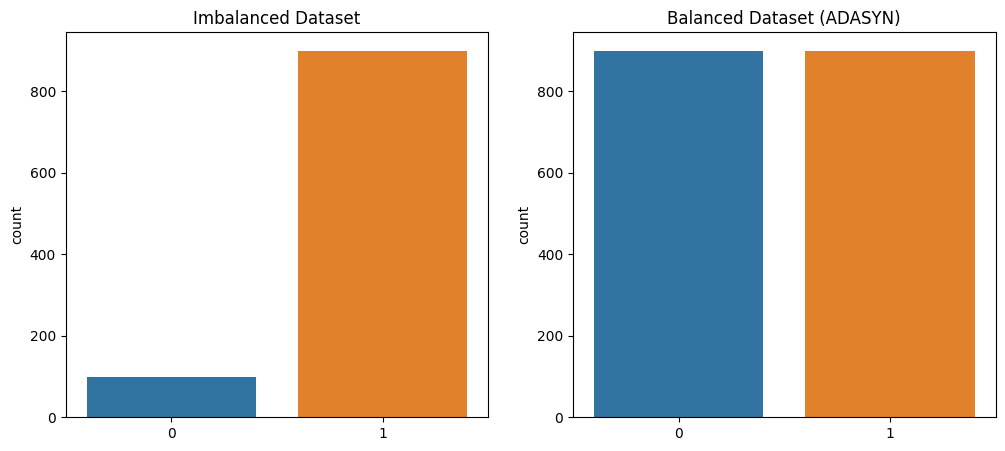

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN
from sklearn.datasets import make_classification

# Create a synthetic imbalanced dataset
X, y = make_classification(n_classes=2, class_sep=2, weights=[0.1, 0.9],
                           n_informative=3, n_redundant=1, flip_y=0, n_features=20,
                           n_clusters_per_class=1, n_samples=1000, random_state=42)

# Visualize the imbalanced dataset
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y)
plt.title("Imbalanced Dataset")

# Apply ADASYN to balance the dataset
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Visualize the balanced dataset after applying ADASYN
plt.subplot(1, 2, 2)
sns.countplot(x=y_resampled)
plt.title("Balanced Dataset (ADASYN)")

plt.show()
